In [1]:
import findspark
findspark.init()
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
from pyspark.sql import SparkSession, Column, Row, functions as F 

In [3]:
spark = (SparkSession.builder\
        .master("local[*]")\
        .appName("spark movie recommender")\
        .getOrCreate())
sc = spark.sparkContext

## Data ETL and Exploration

In [4]:
movies = spark.read.load("../movie_recommender/movies.csv", format='csv', header = True)
ratings = spark.read.load("../movie_recommender/ratings.csv", format='csv', header = True)
links = spark.read.load("../movie_recommender/links.csv",format='csv', header = True)
tags = spark.read.load("../movie_recommender/tags.csv",format='csv', header = True)

In [5]:
movies.show(1) 
ratings.show(1)
links.show(1)
tags.show(1)

+-------+----------------+--------------------+
|movieId|           title|              genres|
+-------+----------------+--------------------+
|      1|Toy Story (1995)|Adventure|Animati...|
+-------+----------------+--------------------+
only showing top 1 row

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
+------+-------+------+----------+
only showing top 1 row

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
+-------+-------+------+
only showing top 1 row

+------+-------+--------------------+----------+
|userId|movieId|                 tag| timestamp|
+------+-------+--------------------+----------+
|    15|    339|sandra 'boring' b...|1138537770|
+------+-------+--------------------+----------+
only showing top 1 row



In [6]:
# sparsity
num_users=ratings.select('userId').distinct().count()
num_movies=ratings.select('movieId').distinct().count()
num_ratings = ratings.count()
sparsity=1-(num_ratings*1.0)/(num_users*num_movies)
print("The sparsity is ", sparsity)

('The sparsity is ', 0.9835608583913366)


In [7]:
# List movies not rated before
print("The following movieId are not rated")
all_movies = ratings.select('movieId').union(tags.select('movieId'))
rated = ratings.select('movieId')
not_rated = all_movies.subtract(rated)
not_rated.distinct().show()

The following movieId are not rated
+-------+
|movieId|
+-------+
| 144172|
|  94969|
| 132547|
|   7335|
| 110871|
|   5984|
| 131796|
| 132800|
| 128235|
|  39421|
|  82313|
| 111251|
|  42217|
| 132549|
|   8767|
| 161582|
| 155064|
| 111249|
|  48711|
| 132458|
+-------+
only showing top 20 rows



In [8]:
#Number of movies for each gene category
movies.select('genres').distinct().show()
gene_set = set()
for row in movies.collect():
    gene = row["genres"]
    gene_set.update(gene.split("|"))
gene_set = list(gene_set)
gene=[str(i) for i in gene_set]

gene_count=dict((i, movies.filter(movies["genres"].contains(i)).count()) for i in gene)
print("The number of movies for each category is ",gene_count)

+--------------------+
|              genres|
+--------------------+
|Comedy|Horror|Thr...|
|Adventure|Sci-Fi|...|
|Action|Adventure|...|
| Action|Drama|Horror|
|Comedy|Drama|Horr...|
|Action|Animation|...|
|Animation|Childre...|
|Action|Adventure|...|
| Adventure|Animation|
|    Adventure|Sci-Fi|
|Documentary|Music...|
|Adventure|Childre...|
|  Documentary|Sci-Fi|
| Musical|Romance|War|
|Action|Adventure|...|
|Adventure|Childre...|
|Crime|Drama|Fanta...|
|Comedy|Mystery|Th...|
|   Adventure|Fantasy|
|Action|Animation|...|
+--------------------+
only showing top 20 rows

('The number of movies for each category is ', {'Mystery': 543, 'Romance': 1545, 'IMAX': 153, 'Sci-Fi': 792, 'Horror': 877, 'Film-Noir': 133, 'Crime': 1100, 'Drama': 4365, 'Fantasy': 654, 'Animation': 447, 'War': 367, 'Western': 168, 'Children': 583, 'Action': 1545, '(no genres listed)': 18, 'Comedy': 3315, 'Documentary': 495, 'Musical': 394, 'Thriller': 1729, 'Adventure': 1117})


In [9]:
#Rating distribution
print("The rating distribution")
rd=ratings.select('rating').groupBy('rating').count().orderBy("rating").show()

The rating distribution
+------+-----+
|rating|count|
+------+-----+
|   0.5| 1101|
|   1.0| 3326|
|   1.5| 1687|
|   2.0| 7271|
|   2.5| 4449|
|   3.0|20064|
|   3.5|10538|
|   4.0|28750|
|   4.5| 7723|
|   5.0|15095|
+------+-----+



## Collaborative Filtering
### With ALS algorithm, we can use gird search to tune the hyperparameters 

In [10]:
def grid_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            model = ALS.train(train_data, rank, iterations = num_iters, lambda_ = reg)
            predictions = model.predictAll(validation_data.map(lambda x: (x[0], x[1]))).map(lambda x: ((x[0], x[1]), x[2]))
            rate_and_preds = validation_data.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predictions)
            error = math.sqrt(rate_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [11]:
# Prep: RDD based API
# reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.
from pyspark.mllib.recommendation import ALS,MatrixFactorizationModel, Rating
movie_rating = sc.textFile("../movie_recommender/ratings.csv")
header = movie_rating.take(1)[0]
rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda x: (x[0],x[1],x[2]))

train, validation, test = rating_data.randomSplit([6,2,2],seed = 7856)
test_RDD = test.map(lambda x: (x[0], x[1]))

# With the ALS model, we can use a grid search to find the optimal hyperparameters.
num_iterations = 10
ranks = [8, 10, 12]
reg_params = [0.05, 0.1, 0.2]

import time
start_time = time.time()

final_model = grid_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.05: validation RMSE is 1.04127692828
8 latent factors and regularization = 0.1: validation RMSE is 0.959453703021
8 latent factors and regularization = 0.2: validation RMSE is 0.937054258064
10 latent factors and regularization = 0.05: validation RMSE is 1.05954349932
10 latent factors and regularization = 0.1: validation RMSE is 0.965392217993
10 latent factors and regularization = 0.2: validation RMSE is 0.936760044029
12 latent factors and regularization = 0.05: validation RMSE is 1.04863309899
12 latent factors and regularization = 0.1: validation RMSE is 0.960966780654
12 latent factors and regularization = 0.2: validation RMSE is 0.934213475984

The best model has 12 latent factors and regularization = 0.2
Total Runtime: 89.42 seconds


In [12]:
def plot_learning_curve(iter_setting, train_data, validation_data, reg, rank):
    train_rmse = []
    valid_rmse = []
    for iteration in iter_setting:
        
        model = ALS.train(train_data, rank, iterations = iteration, lambda_ = reg)
        
        # Training RMSE 
        predictions = model.predictAll(train_data.map(lambda x: (x[0], x[1])))\
                      .map(lambda x: ((x[0], x[1]), x[2]))
        rate_and_preds = train_data.map(lambda x: ((int(x[0]), int(x[1])), float(x[2])))\
                         .join(predictions)
        error = math.sqrt(rate_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
        train_rmse.append(error)
        # Validation RMSE 
        predictions = model.predictAll(validation_data.map(lambda x: (x[0], x[1])))\
                      .map(lambda x: ((x[0], x[1]), x[2]))
        rate_and_preds = validation_data.map(lambda x: ((int(x[0]), int(x[1])), float(x[2])))\
                         .join(predictions)
        error = math.sqrt(rate_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
        valid_rmse.append(error)
             
    plt.plot(iter_setting, train_rmse, label='Training', linewidth=5)
    plt.plot(iter_setting, valid_rmse, label='Validation', linewidth=5)
    plt.xticks(range(0, max(iter_setting) + 1, 2), fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('iterations', fontsize=30)
    plt.ylabel('RMSE', fontsize=30)
    plt.legend(loc='best', fontsize=20) 
    plt.show()

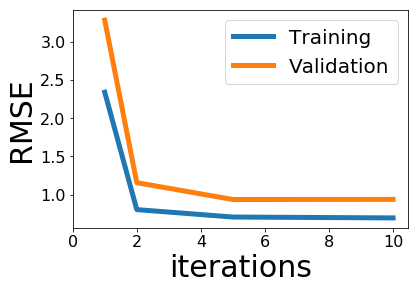

In [13]:
iter_array = [1, 2, 5, 10]
plot_learning_curve(iter_array, train, validation, 0.2, 8)

In [14]:
# check testing error
predictions = final_model.predictAll(test.map(lambda x: (x[0], x[1]))).map(lambda x: ((x[0], x[1]), x[2]))
rates_and_preds = test.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
print ('For testing data the RMSE is %s' % (error))

For testing data the RMSE is 0.908986799055


The error is slightly better than validation RMSE.

## Top 20 Recommendation for New User with more than 50 ratings by others

In [15]:
new_user_ID = 0
new_user_RDD = sc.parallelize([
     (0,260,4), # Star Wars (1977)
     (0,1,3), # Toy Story (1995)
     (0,16,3), # Casino (1995)
     (0,25,4), # Leaving Las Vegas (1995)
     (0,32,4), # Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
     (0,335,1), # Flintstones, The (1994)
     (0,379,1), # Timecop (1994)
     (0,296,3), # Pulp Fiction (1994)
     (0,858,5) , # Godfather, The (1972)
     (0,50,4) # Usual Suspects, The (1995)
])
# convert rated list for new user
new_user_rated=new_user_RDD.map(lambda x: x[1]).collect()
# all users id
all_movies_id= movies.select("movieId").distinct().rdd.flatMap(lambda x: x).collect()
all_movies_id= [int(x) for x in all_movies_id]
# unrated for new user 0
unrated=[(0,x) for x in all_movies_id if x not in new_user_rated]
unrated_RDD=sc.parallelize(unrated)

In [16]:
# all movies titles tuple and all ratings counts tuple
all_movies_titles = movies.select("movieId","title")\
                    .rdd.map(lambda x: (int(x[0]),x[1])).collect()
all_rating_counts = ratings.select('movieId').groupBy('movieId').count()\
                    .orderBy("count",ascending=False)\
                    .rdd.map(lambda x: (int(x[0]),x[1])).collect()
t=sc.parallelize(all_movies_titles)
c=sc.parallelize(all_rating_counts)

# train new model with new total data
added_total_rating=rating_data.union(new_user_RDD)
# predict unrated movie for new user
new_model=ALS.train(added_total_rating,8,10,0.2)
# convert to (movieId, rating) for unrated movies
new_recommend=new_model.predictAll(unrated_RDD).map(lambda x: (x[1], x[2]))

In [17]:
recommendation=t.join(c).join(new_recommend)\
               .map(lambda x: (x[0],x[1][0][0],x[1][1],x[1][0][1]))
top20=recommendation.filter(lambda x: x[3]>=50).takeOrdered(20, key=lambda x: -x[2])
print ('TOP recommended movies (with more than 20 reviews):\n%s' %
        '\n'.join(map(str, top20)))

TOP recommended movies (with more than 20 reviews):
(1252, u'Chinatown (1974)', 3.8223591375164623, 76)
(913, u'Maltese Falcon, The (1941)', 3.7880575533141325, 62)
(2019, u'Seven Samurai (Shichinin no samurai) (1954)', 3.7808703305903824, 54)
(1230, u'Annie Hall (1977)', 3.764281499805653, 80)
(750, u'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 3.7554191081646247, 105)
(903, u'Vertigo (1958)', 3.7503751676418213, 69)
(1228, u'Raging Bull (1980)', 3.7407110800815877, 50)
(111, u'Taxi Driver (1976)', 3.7279950545952225, 118)
(923, u'Citizen Kane (1941)', 3.7229807753573865, 85)
(904, u'Rear Window (1954)', 3.7075527567766224, 92)
(1221, u'Godfather: Part II, The (1974)', 3.702161064537438, 135)
(1219, u'Psycho (1960)', 3.7015143816116423, 77)
(908, u'North by Northwest (1959)', 3.6941362621849367, 87)
(745, u'Wallace & Gromit: A Close Shave (1995)', 3.6854539360723284, 62)
(608, u'Fargo (1996)', 3.6733066535645382, 224)
(912, u'Casablanca (1942)', 3.667